In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("/home/maurizio/Documents/projects/coronavirus")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import src.tools as tools
import plotly.express as px
from scipy.integrate import odeint
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
from src.data_downloader import DATA_REPOS, download_from_repo

### download data from repos

In [2]:
dest='/home/maurizio/Documents/projects/coronavirus/data'

In [3]:
DATA_REPOS

{'world': {'url': 'https://github.com/CSSEGISandData/COVID-19',
  'streams': {'deaths': '/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv',
   'confirmed': '/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv',
   'recovered': '/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'}},
 'italy': {'url': 'https://github.com/pcm-dpc/COVID-19',
  'streams': {'andamento-nazionale': '/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv',
   'regioni': '/dati-regioni/dpc-covid19-ita-regioni.csv',
   'province': '/dati-province/dpc-covid19-ita-province.csv'}}}

In [4]:
download_from_repo(DATA_REPOS['world']['url'], filename=DATA_REPOS['world']['streams']['deaths'], 
                   dest='/home/maurizio/Documents/projects/coronavirus/data')

In [5]:
download_from_repo(DATA_REPOS['world']['url'], filename=DATA_REPOS['world']['streams']['confirmed'], 
                   dest='/home/maurizio/Documents/projects/coronavirus/data')

In [6]:
download_from_repo(DATA_REPOS['world']['url'], filename=DATA_REPOS['world']['streams']['recovered'], 
                   dest='/home/maurizio/Documents/projects/coronavirus/data')

In [7]:
download_from_repo(DATA_REPOS['italy']['url'], filename=DATA_REPOS['italy']['streams']['andamento-nazionale'], 
                   dest='/home/maurizio/Documents/projects/coronavirus/data')

In [8]:
download_from_repo(DATA_REPOS['italy']['url'], filename=DATA_REPOS['italy']['streams']['regioni'], 
                   dest='/home/maurizio/Documents/projects/coronavirus/data')

In [9]:
download_from_repo(DATA_REPOS['italy']['url'], filename=DATA_REPOS['italy']['streams']['province'], 
                   dest='/home/maurizio/Documents/projects/coronavirus/data')

### SIRD Model definition

In [143]:
# SIR model differential equations
def SIR_deriv(y, t, N, beta, gamma, theta):
    S, I, R, D = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    dDdt = theta * I
    return dSdt, dIdt, dRdt, dDdt

def SIRModel_solver(t, beta, gamma, theta):
    return SIRModel(t, beta, gamma, theta)[3] # returns just D for optimizer

def SIRModel(t, beta, gamma, theta):
    # Initial conditions vector
    y0 = S0, I0, R0, D0
    # Integrate the SIR equations over time t
    ret = odeint(SIR_deriv, y0, t, args=(N, beta, gamma, theta))
    S, I, R, D = ret.T
    return S, I, R, D

def diff_ev_solver(params):
    beta, gamma, theta = params
    return np.mean(np.abs(SIRModel_solver(x_fit, beta, gamma, theta) - y_fit))

### toy example

beta:  0.2
gamma:  0.1
theta:  0.015
r0:  2.0
mean period of time of infection:  10.0


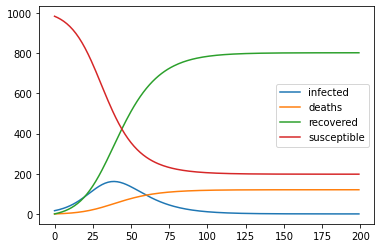

In [144]:
N = 1000 # total population Italy
I0 = 16 # Initial number of infected people (10x official estimates hypothesis)
R0 = 0 # Initial number of recovered
S0 = N - I0 - R0 # Initial susceptible population to infection.
D0 = 0 # number of deaths at initial time

params = (0.2, 0.1, 0.015)
S, I , R, D = SIRModel(range(200), *params)
print('beta: ', params[0])
print('gamma: ', params[1])
print('theta: ', params[2])
print('r0: ', params[0]/params[1])
print('mean period of time of infection: ', 1/params[1])

plt.plot(I, label='infected')
plt.plot(D, label='deaths')
plt.plot(R, label='recovered')
plt.plot(S, label='susceptible')
#plt.yscale('log')
#ax.yaxis.set_major_formatter(ScalarFormatter())

#plt.ylim(0,10000)
plt.legend()

### fit to official death data

calibrating with genetic algorithm...
beta:  2.6615053155728585
gamma:  2.4106178921077417
theta:  0.0015062263334708614
r0:  1.103386552634283
mean period of time of infection:  0.4148314020542022
max number of infections  279305.4878012916
max number of deaths  6899.312879824244
mae  27.090202822375183


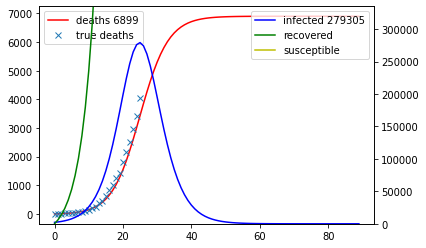

In [148]:
use_differential_evolution = True
cases_multiplier = 10
df = pd.read_csv('../data/dpc-covid19-ita-andamento-nazionale.csv').drop('stato',1)
y_fit = df['deceduti'].values
x_fit = np.linspace(0, len(y_fit), len(y_fit))
N = 60431283 # total population Italy
I0 = cases_multiplier*df['totale_attualmente_positivi'].iloc[0] # Initial number of infected people (10x official estimates hypothesis)
R0 = 0 #df['dimessi_guariti'].iloc[0] # Initial number of recovered
S0 = N - I0 - R0 # Initial susceptible population to infection.
D0 = 0 # number of deaths at initial time

bounds = [(-5,5), (-5, 5), (-5, 5)]
if use_differential_evolution:
    print('calibrating with genetic algorithm...')
    optimization = differential_evolution(diff_ev_solver, bounds)
    params = optimization.x
else:
    params, covariances = curve_fit(f=SIRModel_solver, xdata=x_fit, ydata=y_fit, method='trf', bounds=bounds[0])
S, I , R, D = SIRModel(range(90), *params)
print('beta: ', params[0])
print('gamma: ', params[1])
print('theta: ', params[2])
print('r0: ', params[0]/(params[1]+params[2]))
print('mean period of time of infection: ', 1/params[1])
print('max number of infections ', np.max(I))
print('max number of deaths ', np.max(D))
print('mae ', np.mean(np.abs(y_fit - SIRModel_solver(x_fit, *params))))
fig, ax1 = plt.subplots()
ax1.plot(D,'r', label='deaths '+str(int(np.max(D))))
ax1.plot(y_fit,'x', label='true deaths')
ax1.legend(loc='upper left')
ax2 = ax1.twinx()
plt.ylim(0,1.2*np.max(I))
ax2.plot(I,'b', label='infected '+str(int(np.max(I))))
ax2.plot(R,'g', label='recovered')
ax2.plot(S,'y', label='susceptible')


ax2.legend()

### SEIR Model definition

In [150]:
# SEIR model differential equations
def SEIR_deriv(y, t, rho, thau_inf, thau_inc, theta):
    S, E, I, R, D = y
    dSdt = -rho/thau_inf * S * I
    dEdt = rho/thau_inf * S * I - E/thau_inc
    dIdt = E/thau_inc - I/thau_inf - theta*I
    dRdt = I/thau_inf
    dDdt = theta * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

def SEIRModel_solver(t, rho, thau_inf, thau_inc, theta):
    return SEIRModel(t, rho, thau_inf, thau_inc, theta)[4] # returns just D for optimizer

def SEIRModel(t, rho, thau_inf, thau_inc, theta):
    # Initial conditions vector
    y0 = S0, E0, I0, R0, D0
    # Integrate the SIR equations over time t
    ret = odeint(SEIR_deriv, y0, t, args=(rho, thau_inf, thau_inc, theta))
    S, E, I, R, D = ret.T
    return S, E, I, R, D

def diff_ev_solver(params):
    rho, thau_inf, thau_inc, theta = params
    return np.mean(np.abs(SEIRModel_solver(x_fit, rho, thau_inf, thau_inc, theta) - y_fit))

In [151]:
SEIRModel((1,2), 2.5, 5, 0.3, 0.023)

(array([ 6.04290730e+07, -1.24703011e-14]),
 array([      0.       , 2157579.2027748]),
 array([2.21000000e+03, 4.95091822e+07]),
 array([      0.        , 7860557.52357135]),
 array([     0.        , 903964.11521071]))

Tinf:  21.381454104877854
Tinc:  49.86465135380795
r0:  11.739423732985722
mean period of time of infection:  0.04676950384641357
max number of infections  29333.09891764135
max number of deaths  50226532.016471885
mae  12085706.638461564


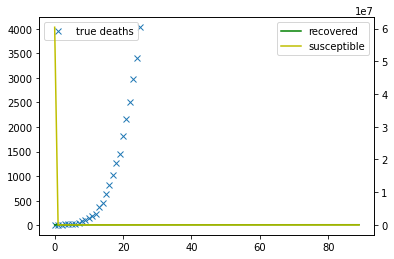

In [154]:
use_differential_evolution = False
cases_multiplier = 10
df = pd.read_csv('../data/dpc-covid19-ita-andamento-nazionale.csv').drop('stato',1)
y_fit = df['deceduti'].values
x_fit = np.linspace(0, len(y_fit), len(y_fit))
N = 60431283 # total population Italy
I0 = cases_multiplier*df['totale_attualmente_positivi'].iloc[0] # Initial number of infected people (10x official estimates hypothesis)
R0 = 0 #df['dimessi_guariti'].iloc[0] # Initial number of recovered
S0 = N - I0 - R0 # Initial susceptible population to infection.
D0 = 0 # number of deaths at initial time
E0 = 0
bounds = [(0,50), (0, 50), (0, 50), (0, 5)]
if use_differential_evolution:
    print('calibrating with genetic algorithm...')
    optimization = differential_evolution(diff_ev_solver, bounds)
    params = optimization.x
else:
    params, covariances = curve_fit(f=SEIRModel_solver, xdata=x_fit, ydata=y_fit, method='trf', bounds=bounds[0])
S, E, I, R, D = SEIRModel(range(90), *params)
print('Tinf: ', params[1])
print('Tinc: ', params[2])
print('r0: ', params[0])
print('mean period of time of infection: ', 1/params[1])
print('max number of infections ', np.max(I))
print('max number of deaths ', np.max(D))
print('mae ', np.mean(np.abs(y_fit - SEIRModel(x_fit, *params))))
fig, ax1 = plt.subplots()
#ax1.plot(D,'r', label='deaths '+str(int(np.max(D))))
ax1.plot(y_fit,'x', label='true deaths')
ax1.legend(loc='upper left')
ax2 = ax1.twinx()
#plt.ylim(0,1.2*np.max(I))
#ax2.plot(I,'b', label='infected '+str(int(np.max(I))))
ax2.plot(R,'g', label='recovered')
ax2.plot(S,'y', label='susceptible')


ax2.legend()

In [161]:
def func(y, t, N, I0, R0, D_incubation, D_infectious, D_recovery_mild, 
         D_hospital_lag, D_recovery_severe, D_death, P_SEVERE, CFR, 
         InterventionTime, InterventionAmt, duration):
    
    interpolation_steps = 40
    var steps = 110*interpolation_steps
    var dt = dt/interpolation_steps
    var sample_step = interpolation_steps
# SEIR ODE
    if (t > InterventionTime & t < InterventionTime + duration):
        beta = (InterventionAmt)*R0/(D_infectious)
    elif(t > InterventionTime + duration):
        beta = 0.5*R0/(D_infectious)        
    else:
        beta = R0/(D_infectious)

    a     = 1/D_incubation
    gamma = 1/D_infectious

    S         = x[0] # Susectable
    E         = x[1] # Exposed
    I         = x[2] # Infectious 
    Mild      = x[3] # Recovering (Mild)     
    Severe    = x[4] # Recovering (Severe at home)
    Severe_H  = x[5] # Recovering (Severe in hospital)
    Fatal     = x[6] # Recovering (Fatal)
    R_Mild    = x[7] # Recovered
    R_Severe  = x[8] # Recovered
    R_Fatal   = x[9] # Dead
    p_severe  = P_SEVERE
    p_fatal   = CFR
    p_mild    = 1 - P_SEVERE - CFR
    dS        = -beta*I*S
    dE        =  beta*I*S - a*E
    dI        =  a*E - gamma*I
    dMild     =  p_mild*gamma*I   - (1/D_recovery_mild)*Mild
    dSevere   =  p_severe*gamma*I - (1/D_hospital_lag)*Severe
    dSevere_H =  (1/D_hospital_lag)*Severe - (1/D_recovery_severe)*Severe_H
    dFatal    =  p_fatal*gamma*I  - (1/D_death)*Fatal
    dR_Mild   =  (1/D_recovery_mild)*Mild
    dR_Severe =  (1/D_recovery_severe)*Severe_H
    dR_Fatal  =  (1/D_death)*Fatal
    
    return dS, dE, dI, dMild, dSevere, dSevere_H, dFatal, dR_Mild, dR_Severe, dR_Fatal